In [1]:
import os
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob

In [2]:
def plot_trade(coin):
    fig, ax = plt.subplots(3, 3, figsize=(15, 15), dpi=100)
    fig.suptitle('RL-Based Strategy ({}), Test Set'.format(coin))

    for m in ["A2C", "ACKTR", "PPO"]:
        valu_dirs = glob(os.getcwd()+"\\results\\sharpe\\"+coin+"\\*value_trade_"+m+"*")
        hold_dirs = glob(os.getcwd()+"\\results\\sharpe\\"+coin+"\\*holding_trade_"+m+"*")
        
        for i, d in enumerate(valu_dirs):
            data = pd.read_csv(d)
            data = data.drop(columns=["Unnamed: 0"])
            data = data.rename(columns={"0":"account_value"})

            ax[0, i].plot(data, label=m)
            ax[0, i].set_title("Q"+str(i+2)+" - Value")
            ax[0, i].legend()
            
        for i, d in enumerate(hold_dirs):
            data = pd.read_csv(d)
            data = data.drop(columns=["Unnamed: 0"])
            data = data.rename(columns={"0":"account_holdings"})

            ax[1, i].plot(data, label=m)
            ax[1, i].set_title("Q"+str(i+2)+" - Holding")
            ax[1, i].legend()
           
    price_dir = glob(os.getcwd()+'\\data\\00 - Processed\\1d\\'+coin+'*.csv')[0]
    price_data = pd.read_csv(price_dir)
    price_data = price_data[price_data['Open time'] >= '2021-01-01']['Close']
    
    ax[2, 0].plot(price_data[90:180].reset_index(drop=True))
    ax[2, 0].set_title("Q2 - Close Price")
    ax[2, 1].plot(price_data[180:270].reset_index(drop=True))
    ax[2, 1].set_title("Q3 - Close Price")
    ax[2, 2].plot(price_data[270:360].reset_index(drop=True), label=coin)
    ax[2, 2].set_title("Q4 - Close Price")

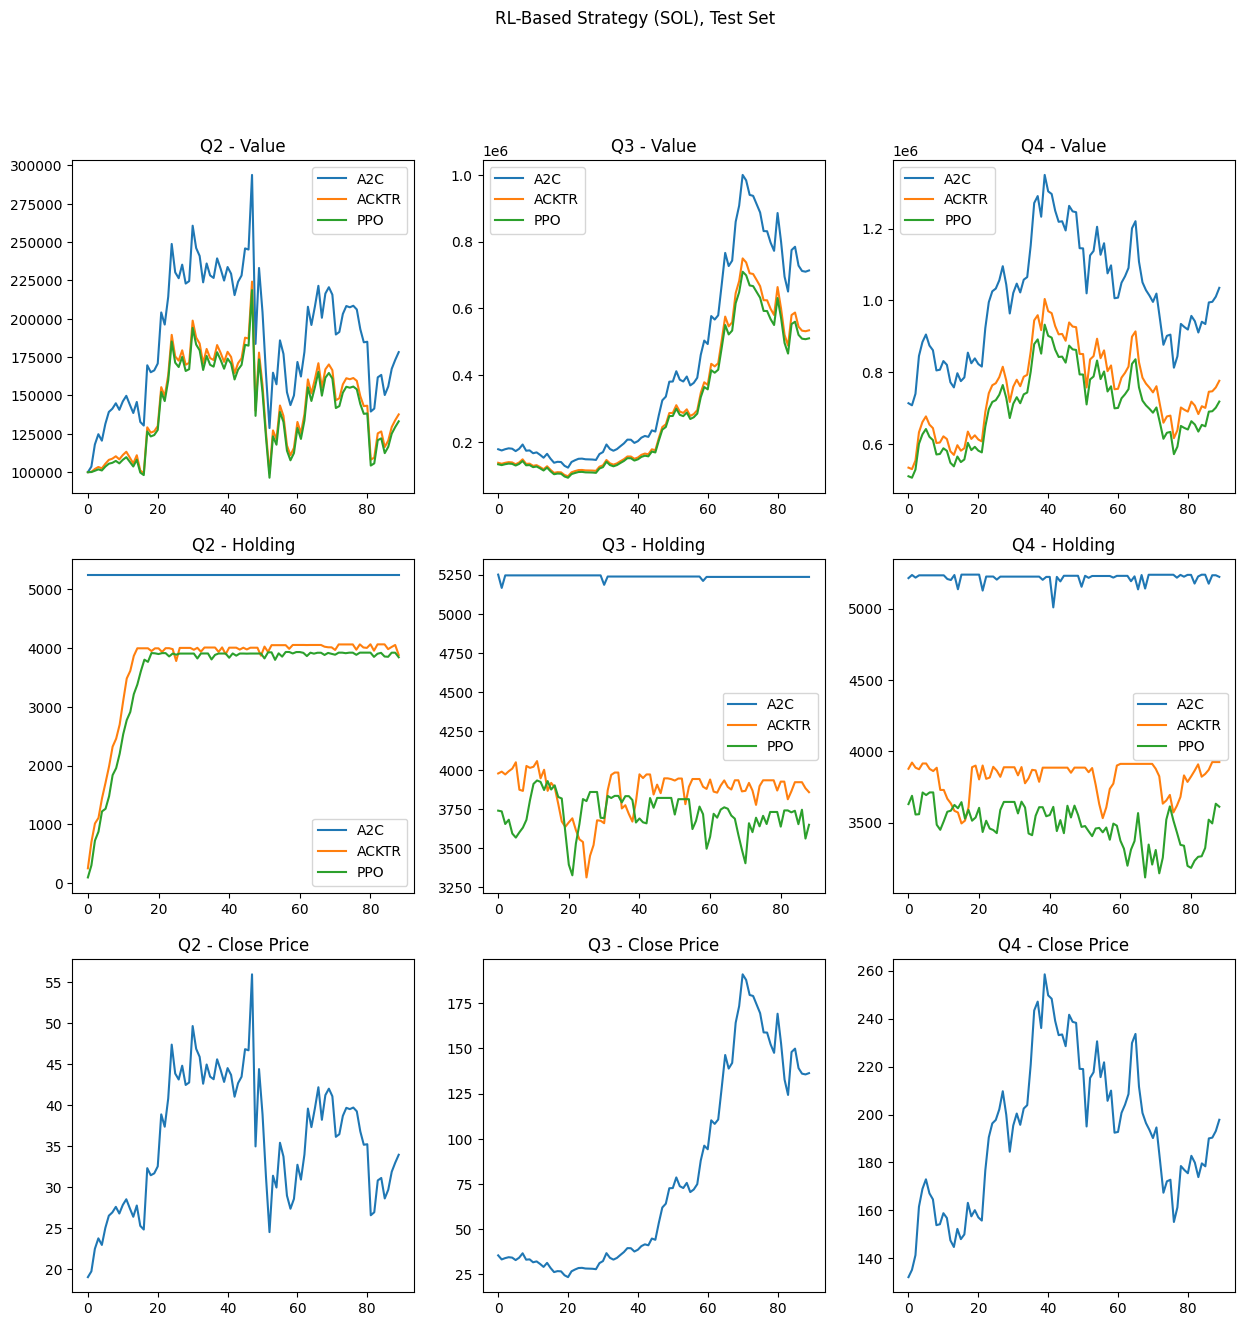

In [3]:
plot_trade('SOL')

In [4]:
def benchmark_BnH(coin):
    """
    Function to calculate the Buy-and-Hold strategy
    
    Input(s) : str
    Output(s): account_value - list
    """
    data = pd.read_csv(glob(os.getcwd() + '\\data\\00 - Processed\\1d\\' + coin + '*.csv')[0])
    data = data.iloc[98:, :].reset_index(drop=True)
    
    investment_value = 100000
    holding = investment_value/data['Close'][0]
    
    account_value = holding * data['Close']
    return account_value.tolist()

def benchmark_schedule(coin):
    """
    Function to calculate the scheduled buying strategy. As the data spans 
    
    Input(s) : str
    Output(s): account_value - list
    """
    data = pd.read_csv(glob(os.getcwd() + '\\data\\00 - Processed\\1d\\'+coin+'*.csv')[0])
    data = data.iloc[98:, :].reset_index(drop=True)
    data['Open time'] = pd.to_datetime(data['Open time'])

    unique_months = pd.to_datetime(data['Open time']).apply(lambda x: (x.year, x.month)).unique()[1:]

    balance = 100000
    holding = 0

    buying_amount_cash = 100000/len(unique_months)

    for year, month in unique_months:
        buying_amount_coin = buying_amount_cash/data.loc[data['Open time'] == str(year)+'-'+str(month).zfill(2)+'-01', 'Close'].values[0]
        balance -= buying_amount_cash
        holding += buying_amount_coin
        data.loc[data['Open time'].apply(lambda x: x.year==year) & data['Open time'].apply(lambda x: x.month==month), 'holding'] = holding
        data.loc[data['Open time'].apply(lambda x: x.year==year) & data['Open time'].apply(lambda x: x.month==month), 'balance'] = balance

    data['holding'] = data['holding'].fillna(0)
    data['balance'] = data['balance'].fillna(100000)
    data['account_value'] = data['balance'] + (data['Close']*data['holding'])
    return data['account_value']

def benchmark_MACD(coin, plot=True):
    """
    Function to calculate the Moving Average Convergence/Divergence strategy
    
    Input(s) : coin - str
    Output(s): data - pd.DataFrame
               buy_price - list
               sell_price - list
               macd_strat_value - list
    """
    data = pd.read_csv(glob(os.getcwd() + '\\data\\00 - Processed\\1d\\' + coin + '*.csv')[0])
    data = data.iloc[98:, :].reset_index(drop=True)
    
    ema_12 = data['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False, min_periods=26).mean()

    macd = ema_12 - ema_26
    macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
    macd_h = macd - macd_s
    data['MACD'] = macd
    data['MACD_S'] = macd_s
    data['MACD_H'] = macd_h
    
    def _calc_strat(price, data):
        """
        Internal function to calculate account value based on the Moving Average Convergence/Divergence strategy
        The strategy is based around generating a buy signal when the MACD value crosses above its signal value,
        and likewise a sell signal when the MACD value crosses below its signal value.
        
        Input(s) : pd.DataFrame
        Output(s): pd.Series
        """
        buy_price   = []
        sell_price  = []
        macd_signal = []
        signal = 0

        for i in range(len(data)):
            if data['MACD'][i] > data['MACD_S'][i]:
                if signal != 1:
                    buy_price.append(price[i])
                    sell_price.append(np.nan)
                    signal = 1
                    macd_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    macd_signal.append(0)
            elif data['MACD'][i] < data['MACD_S'][i]:
                if signal != -1:
                    buy_price.append(np.nan)
                    sell_price.append(price[i])
                    signal = -1
                    macd_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    macd_signal.append(0)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        return buy_price, sell_price, macd_signal
    
    def _plot_MACD_strat():
        """
        Internal function to plot the buy/sell indicators based on Moving Average Convergence/Divergence strategy
        """
        fig, ax = plt.subplots(2, 1, figsize=(20,10), dpi=100)

        ax[0].plot(pd.to_datetime(data['Open time']), data['Close'], label=coin+' (Close)')
        ax[0].plot(pd.to_datetime(data['Open time']), buy_price, marker='^', color='green', markersize=4, label='Buy Signal', linewidth=0)
        ax[0].plot(pd.to_datetime(data['Open time']), sell_price, marker='v', color='red', markersize=4, label='Sell Signal', linewidth=0)
        ax[0].set_title('MACD-Based Strategy ({})'.format(coin))
        ax[0].legend()

        ax[1].plot(pd.to_datetime(data['Open time']), data['MACD'], color='grey', label='MACD')
        ax[1].plot(pd.to_datetime(data['Open time']), data['MACD_S'], color='skyblue', label='MACD Signal')

        for i in range(len(data)):
            if str(data['MACD_H'][i])[0] == '-':
                ax[1].bar(pd.to_datetime(data['Open time'][i]), data['MACD_H'][i], color='#ef5350')
            else:
                ax[1].bar(pd.to_datetime(data['Open time'][i]), data['MACD_H'][i], color='#26a69a')
        ax[1].legend()
    
    buy_price, sell_price, macd_signal = _calc_strat(data['Close'], data)
        
    position = np.zeros(len(macd_signal))
    for i in range(len(data['Close'])):
        if macd_signal[i] == 1:
            position[i] = 1
        elif macd_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
    
    data['MACD_pos'] = position
    data_ret = pd.DataFrame(np.diff(data['Close'])).rename(columns = {0:'returns'})
    
    macd_returns = []
    for i in range(len(data_ret)):
        returns = data_ret['returns'][i] * data['MACD_pos'][i]
        macd_returns.append(returns)
    
    investment_value = 100000
    macd_strat_value = [0]
    for i in range(len(macd_returns)):
        trade_size = np.floor(investment_value/data['Close'][i])
        returns = trade_size*macd_returns[i]
        macd_strat_value.append(returns)
    
    macd_returns_total = sum(macd_strat_value)
    profit_percentage = macd_returns_total/investment_value*100
    
    if plot==True:
        _plot_MACD_strat()
        print('Profit gained: ${:.2f}'.format(macd_returns_total))
        print('Profit percentage: {:.2f}%'.format(profit_percentage))
    else:
        pass
    
    return data, buy_price, sell_price, macd_strat_value

Profit gained: $207946.62
Profit percentage: 207.95%


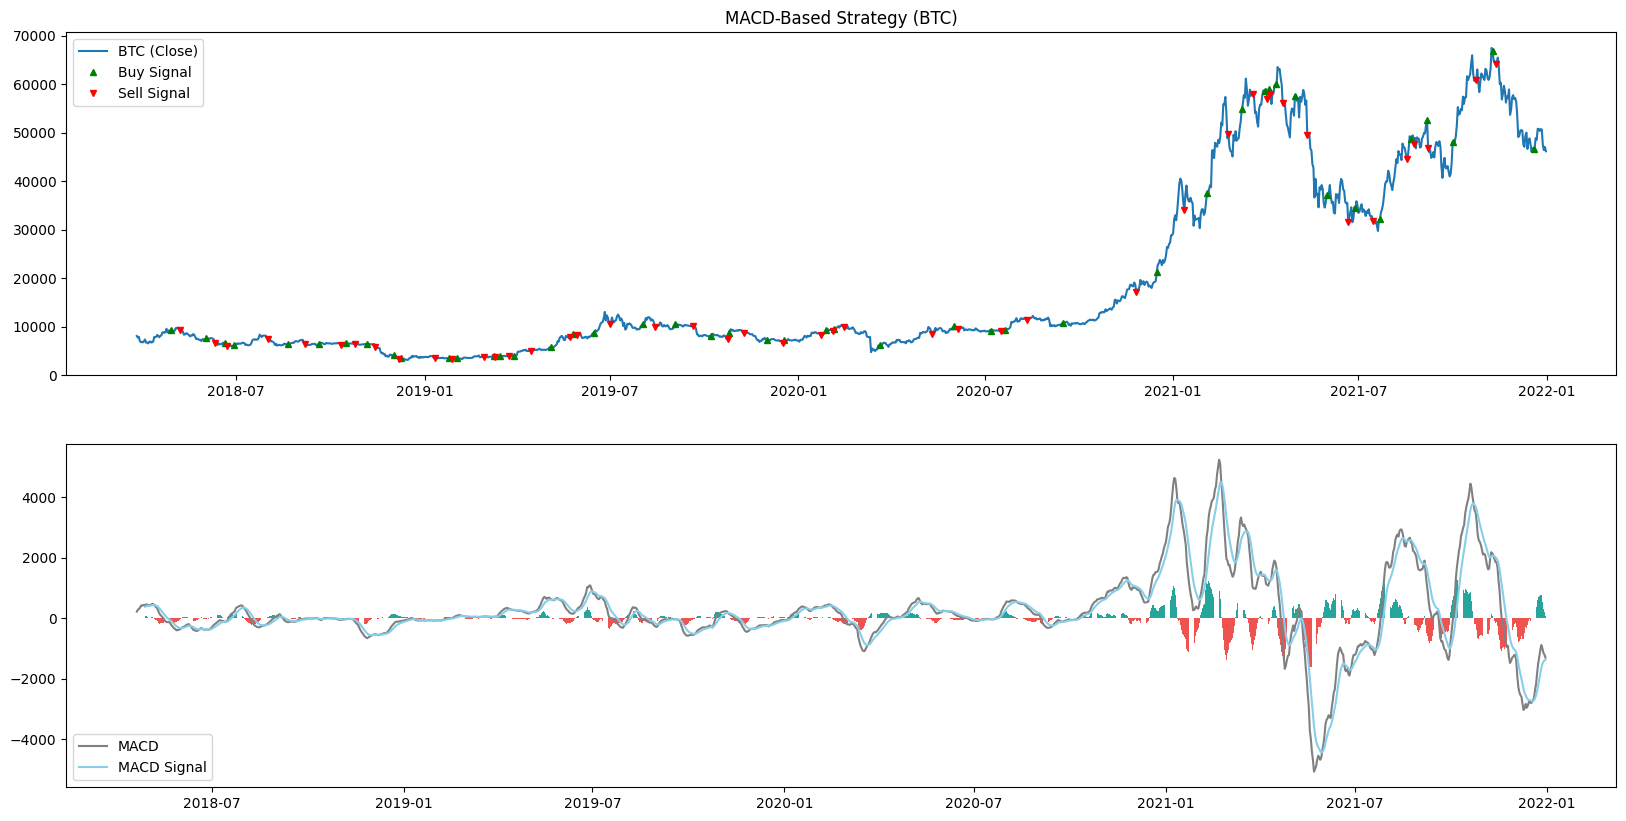

In [5]:
_, _, _, _ = benchmark_MACD('BTC', plot=True)

In [6]:
def eval_benchmarks(coin):
    data, _, _, macd_strat_value = benchmark_MACD(coin, plot=False)
    bnh_strat_value = benchmark_BnH(coin)
    sch_strat_value = benchmark_schedule(coin)
    
    plt.figure(figsize=(20,10), dpi=100)
    
    for m in ["A2C", "ACKTR", "PPO"]:
        dirs = glob(os.getcwd()+"\\results\\sharpe\\"+coin+"\\*value_train_"+m+"*")

        agent_data = pd.read_csv(dirs[0])
        agent_data = agent_data.drop(columns=["Unnamed: 0"])
        agent_data = agent_data.rename(columns={"0":"account_value"})

        plt.plot(pd.to_datetime(data['Open time'][:len(agent_data)]), agent_data, label=m)

    plt.plot(pd.to_datetime(data['Open time'][:len(agent_data)]), 100000+np.cumsum(macd_strat_value)[:len(agent_data)], label='MACD')
    plt.plot(pd.to_datetime(data['Open time'][:len(agent_data)]), bnh_strat_value[:len(agent_data)], label='Buy-and-Hold')
    plt.plot(pd.to_datetime(data['Open time'][:len(agent_data)]), sch_strat_value[:len(agent_data)], label='Scheduled Buying')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title('Account Value ({})'.format(coin))   
    plt.legend()

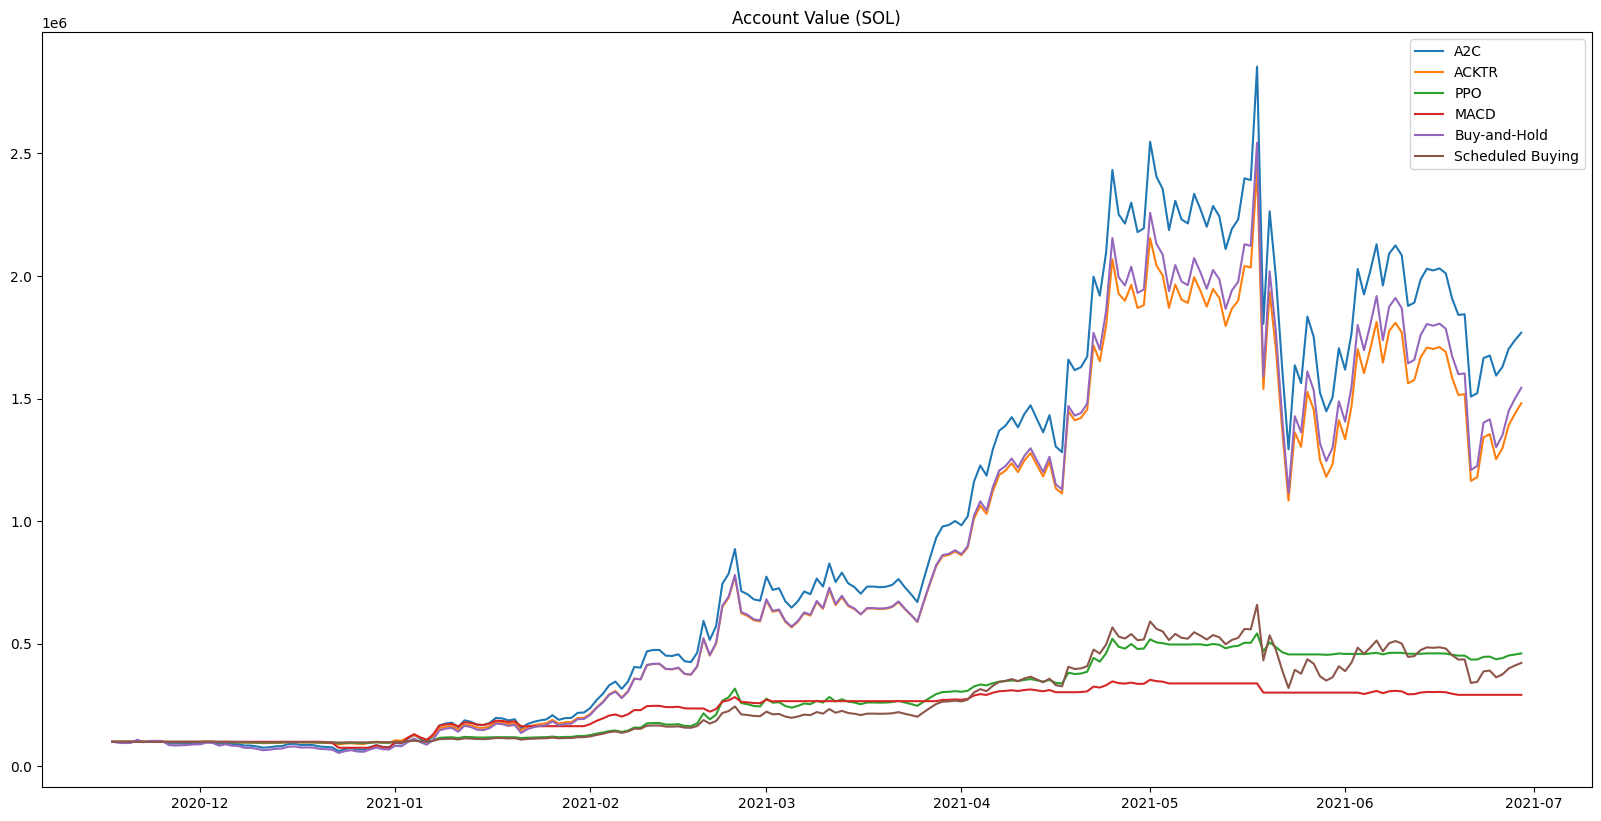

In [7]:
eval_benchmarks('SOL')

In [8]:
def calc_perf_metrics_train(coin):
    
    def _read_RL_data(coin, m):
        dirs = glob(os.getcwd()+"\\results\\sharpe\\"+coin+"\\*value_train_"+m+"*")

        agent_data = pd.read_csv(dirs[0])
        agent_data = agent_data.drop(columns=["Unnamed: 0"])
        agent_data = agent_data.rename(columns={"0":"account_value"})
        return agent_data["account_value"].tolist()

    data, _, _, macd_strat_value = benchmark_MACD(coin, plot=False)
    bnh_strat_value = benchmark_BnH(coin)
    sch_strat_value = benchmark_schedule(coin).tolist()
    
    a2c_strat_value = _read_RL_data(coin,"A2C")
    acktr_strat_value = _read_RL_data(coin, "ACKTR")
    ppo_strat_value = _read_RL_data(coin, "PPO")
    
    macd_strat_value = 100000+np.cumsum(macd_strat_value)[:len(a2c_strat_value)]
    bnh_strat_value = bnh_strat_value[:len(a2c_strat_value)]
    sch_strat_value = sch_strat_value[:len(a2c_strat_value)]
    
    print("Final account value for A2C strategy on", coin+":", "${:.2f}".format(a2c_strat_value[-1]))
    print("Final account value for ACKTR strategy on", coin+":", "${:.2f}".format(acktr_strat_value[-1]))
    print("Final account value for PPO strategy on", coin+":", "${:.2f}".format(ppo_strat_value[-1]))
        
    print("Final account value for MACD trend-following strategy on", coin+":", "${:.2f}".format(macd_strat_value[-1]))
    print("Final account value for Buy-and-Hold strategy on", coin+":", "${:.2f}".format(bnh_strat_value[-1]))
    print("Final account value for Scheduled Buying strategy on", coin+":", "${:.2f}".format(sch_strat_value[-1]))
    print("")
    
    def _calc_APY(data):
        total_profit_pct = (data[-1]/100000 - 1)*100
        annual_profit_pct = total_profit_pct/len(data)*365
        return annual_profit_pct
    
    print("Annualized percent profit for A2C strategy on", coin+":", "{:.2f}%".format(_calc_APY(a2c_strat_value)))
    print("Annualized percent profit for ACKTR strategy on", coin+":", "{:.2f}%".format(_calc_APY(acktr_strat_value)))
    print("Annualized percent profit for PPO strategy on", coin+":", "{:.2f}%".format(_calc_APY(ppo_strat_value)))
    
    print("Annualized percent profit for MACD trend-following strategy on", coin+":", "{:.2f}%".format(_calc_APY(macd_strat_value)))
    print("Annualized percent profit for Buy-and-Hold strategy on", coin+":", "{:.2f}%".format(_calc_APY(bnh_strat_value)))
    print("Annualized percent profit for Scheduled Buying strategy on", coin+":", "{:.2f}%".format(_calc_APY(sch_strat_value)))
    print("")
    
    def _calc_volatility(data):
        data = pd.DataFrame(data)
        daily_pct_return = data.pct_change(1)*100
        std_dev_return = np.std(daily_pct_return)[0]
        annual_volatility = (365**0.5) * std_dev_return
        return annual_volatility
    
    print("Annualized volatility for A2C strategy on BTC:", "{:.2f}%".format(_calc_volatility(a2c_strat_value)))
    print("Annualized volatility for ACKTR strategy on BTC:", "{:.2f}%".format(_calc_volatility(acktr_strat_value)))
    print("Annualized volatility for PPO strategy on BTC:", "{:.2f}%".format(_calc_volatility(ppo_strat_value)))

    print("Annualized volatility for MACD trend-following strategy on", coin+":", "{:.2f}%".format(_calc_volatility(macd_strat_value)))
    print("Annualized volatility for Buy-and-Hold strategy on", coin+":", "{:.2f}%".format(_calc_volatility(bnh_strat_value)))
    print("Annualized volatility for Scheduled Buying strategy on", coin+":", "{:.2f}%".format(_calc_volatility(sch_strat_value)))
    print("")
    
    def _calc_sharpe(data):
        daily_return = np.diff(data, n=1)
        avg_return = np.mean(daily_return)
        std_dev_return = np.std(daily_return)
        annual_sharpe = (365**0.5) * avg_return/std_dev_return
        return annual_sharpe
    
    print("Annualized Sharpe Ratio for A2C strategy on", coin+":", "{:.2f}".format(_calc_sharpe(a2c_strat_value)))
    print("Annualized Sharpe Ratio for ACKTR strategy on", coin+":", "{:.2f}".format(_calc_sharpe(acktr_strat_value)))
    print("Annualized Sharpe Ratio for PPO strategy on", coin+":", "{:.2f}".format(_calc_sharpe(ppo_strat_value)))

    print("Annualized Sharpe Ratio for MACD trend-following strategy on", coin+":", "{:.2f}".format(_calc_sharpe(macd_strat_value)))
    print("Annualized Sharpe Ratio for Buy-and-Hold strategy on", coin+":", "{:.2f}".format(_calc_sharpe(bnh_strat_value)))
    print("Annualized Sharpe Ratio for Scheduled Buying strategy on", coin+":", "{:.2f}".format(_calc_sharpe(sch_strat_value)))

In [9]:
calc_perf_metrics_train('ADA')

Final account value for A2C strategy on ADA: $839871.34
Final account value for ACKTR strategy on ADA: $2429464.54
Final account value for PPO strategy on ADA: $2228345.33
Final account value for MACD trend-following strategy on ADA: $398989.57
Final account value for Buy-and-Hold strategy on ADA: $791400.08
Final account value for Scheduled Buying strategy on ADA: $1698631.71

Annualized percent profit for A2C strategy on ADA: 251.92%
Annualized percent profit for ACKTR strategy on ADA: 793.15%
Annualized percent profit for PPO strategy on ADA: 724.67%
Annualized percent profit for MACD trend-following strategy on ADA: 101.80%
Annualized percent profit for Buy-and-Hold strategy on ADA: 235.41%
Annualized percent profit for Scheduled Buying strategy on ADA: 544.31%

Annualized volatility for A2C strategy on BTC: 115.63%
Annualized volatility for ACKTR strategy on BTC: 103.80%
Annualized volatility for PPO strategy on BTC: 97.18%
Annualized volatility for MACD trend-following strategy o

In [16]:
def plot_rewards(coin):
    
    data = pd.read_csv(glob(os.getcwd() + '\\data\\00 - Processed\\1d\\' + coin + '*.csv')[0])
    data = data.iloc[98:, :].reset_index(drop=True)
    
    rewards_sharpe_dirs = glob(os.getcwd()+"\\results\\sharpe\\"+coin+"\\*rewards_train_PPO*")[0]
    rewards_sharpe_data = pd.read_csv(rewards_sharpe_dirs)
    rewards_sharpe_data = rewards_sharpe_data.drop(columns=["Unnamed: 0"])
    rewards_sharpe_data = rewards_sharpe_data.rename(columns={"0":"rewards_value"})

    rewards_return_dirs = glob(os.getcwd()+"\\results\\returns\\"+coin+"\\*rewards_train_PPO*")[0]
    rewards_return_data = pd.read_csv(rewards_return_dirs)
    rewards_return_data = rewards_return_data.drop(columns=["Unnamed: 0"])
    rewards_return_data = rewards_return_data.rename(columns={"0":"rewards_value"})
    
    fig, ax = plt.subplots(2, 1, figsize=(10,8), dpi=100)
    fig.suptitle('Historical Rewards ({})'.format(coin))
    
    ax[0].set_title('Sharpe Ratio, PPO-Based Strategy')
    ax[0].plot(pd.to_datetime(data['Open time'][:len(rewards_sharpe_data)]), rewards_sharpe_data)
    ax[1].set_title('Simple Returns, PPO-Based Strategy')
    ax[1].plot(pd.to_datetime(data['Open time'][:len(rewards_return_data)]), rewards_return_data)

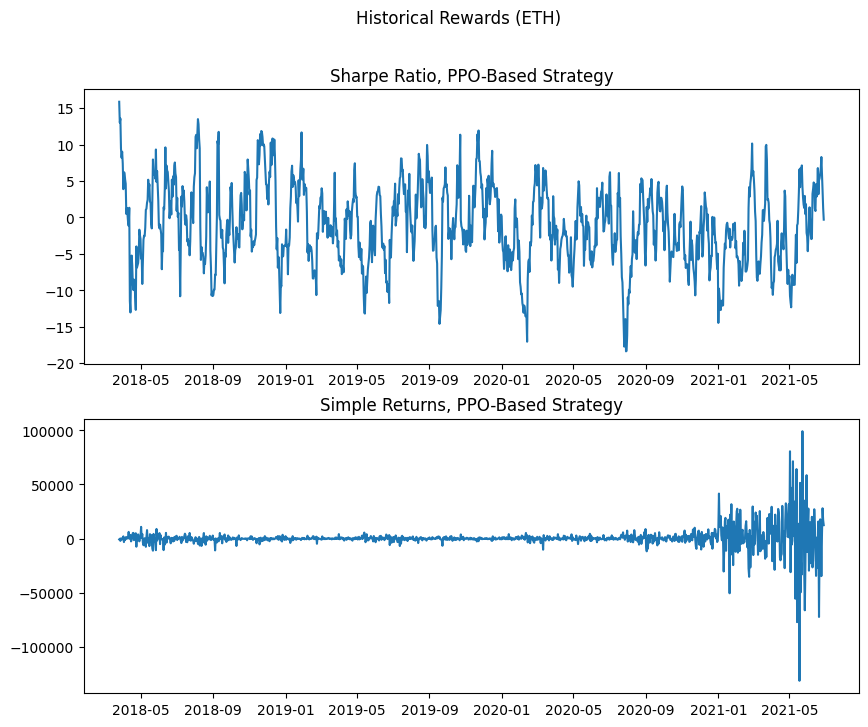

In [17]:
plot_rewards('ETH')

In [ ]:
def calc_perf_metrics_test(coin):
    
    def _read_RL_data(coin, m, i):
        val_dirs = glob(os.getcwd()+"\\results\\sharpe\\"+coin+"\\*value_trade_"+m+"*")
        hol_dirs = glob(os.getcwd()+"\\results\\sharpe\\"+coin+"\\*holding_trade_"+m+"*")
        
        val_data = pd.read_csv(val_dirs[i])
        val_data = val_data.drop(columns=["Unnamed: 0"])
        val_data = val_data.rename(columns={"0":"account_value"})
        
        hol_data = pd.read_csv(hol_dirs[i])
        hol_data = hol_data.drop(columns=["Unnamed: 0"])
        hol_data = hol_data.rename(columns={"0":"account_holding"})
        
        return val_data["account_value"].tolist(), hol_data["account_holding"].tolist()
    
    def _calc_profit_percent(data):
        return (data[-1]-data[0]) / data[0] * 100
    
    def _calc_average_holding(data):
        return np.mean(data)
    
    for i in range(3):
        for m in ['A2C', 'ACKTR', 'PPO']:        
            val_data, hol_data = _read_RL_data(coin, m, i)
            
            profit_percent = _calc_profit_percent(val_data)
            average_holding = _calc_average_holding(hol_data)
            
            print("Q{} profit percent for {} strategy on {}:".format(i+2, m, coin), "{:.2f}%".format(profit_percent))
            print("Q{} average holding for {} strategy on {}:".format(i+2, m, coin), "{:.4f}".format(average_holding))
        print("")

In [ ]:
calc_perf_metrics_test('ADA')